# Scenario/Robustness analysis

In [1]:
# Importing external packages

import os
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
from collections import defaultdict
from tqdm import tqdm
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import dimensional_stacking
import importlib
import warnings

warnings.filterwarnings(action="once")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


In [2]:
# Importing model scripts, by first adding the main folder path

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.model_nile import ModelNile
# from experimentation.data_generation import generate_input_data
import plotter

import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

Read the results of the open exploration:

In [3]:
experiments = pd.read_csv("../outputs/experiments_exploration.csv").drop(
    columns="Unnamed: 0"
)
outcomes = pd.read_csv("../outputs/outcomes_exploration.csv").drop(columns="Unnamed: 0")

In [4]:
outcomes

egypt_def    min_HAD  sudan_def  ethiopia_hydro
0       0.063699  170.04037   0.000000       14.009892
1       0.274312  167.11165   0.000000       13.290453
2       0.003638  178.10178   0.000000       19.099460
3       0.004411  178.72410   0.000000       19.779530
4      18.351717  150.20029   0.107979        7.945507
...          ...        ...        ...             ...
24995   2.341078  171.28539   0.000000       11.083701
24996   0.356826  178.44440   0.000000       17.067026
24997   4.186601  152.72498   0.000000        9.822112
24998   0.378806  175.54305   0.000000       15.475045
24999   0.604246  174.94545   0.000000       15.073878

[25000 rows x 4 columns]

In [5]:
# policy_name_conversion = {
#     "best_egypt_aggregate": "Best Egypt Irr.",
#     "best_egypt_90": "Best Egypt 90$^{th}$",
#     "best_egypt_HAD": "Best Egypt HAD",
#     "best_ethiopia": "Best Ethiopia Hydropower",
#     "compromise_percentile": "Compromise: Percentile",
#     "compromise_threshold": "Compromise: Absolute",
# }
# for i in tqdm(experiments.index):
#     experiments.loc[i, "policy"] = policy_name_conversion[experiments.loc[i, "policy"]]

outcomes["policy"] = experiments["policy"]
outcomes["scenario"] = experiments["scenario"]

In [6]:
outcomes.describe()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


egypt_def       min_HAD     sudan_def  ethiopia_hydro      scenario
count  25000.000000  25000.000000  25000.000000    25000.000000  25000.000000
mean       4.682560    167.268734      0.239986       12.803232   2499.500000
std        6.159486     11.524484      0.541158        3.817323   1443.404512
min        0.000000    148.074190      0.000000        4.146241      0.000000
25%        0.461567    153.542560      0.000000        9.546445   1249.750000
50%        1.706589    174.407285      0.000000       13.296093   2499.500000
75%        6.826838    177.107677      0.116812       16.255215   3749.250000
max       33.929924    179.631180      4.529364       20.065784   4999.000000

In [7]:
# Let's see all objectives against one another, policies color-coded:
# sns.pairplot(
#     outcomes,
#     hue="policy",
#     vars=outcomes.keys(),
#     diag_kind="hist",
#     plot_kws={"s": 5},
#     palette="viridis",
# )
# plt.xticks(rotation=45)
# plt.savefig("../plots/scenario_analysis/policy_performances_pairplot.svg")
# plt.show()

## Percentile compromise seems to be performing very well even in terms of Ethiopia Hydropower almost as good as the best Ethiopia policy. Check if they perform the same in all scenarios, or in certain scenarios compromise is better or vice versa!

In [8]:
# All the factors for global sensitivity analysis in the same dataframe:
experiments.iloc[:, [0, 1, -2]]

mean_factor  stdev_factor                          policy
0         1.023735      1.370793           Best Egypt Irrigation
1         0.992974      1.279861           Best Egypt Irrigation
2         1.329207      1.453746           Best Egypt Irrigation
3         1.381488      1.238576           Best Egypt Irrigation
4         0.614741      1.347450           Best Egypt Irrigation
...            ...           ...                             ...
24995     0.854976      1.136381  Compromise: Absolute Threshold
24996     1.249721      1.314775  Compromise: Absolute Threshold
24997     0.815499      1.102843  Compromise: Absolute Threshold
24998     1.152665      1.317021  Compromise: Absolute Threshold
24999     1.173169      1.396612  Compromise: Absolute Threshold

[25000 rows x 3 columns]

In [9]:
# OOIs must be prepared as a dict with name in key and np arrays in value for the feature scoring:

out_dict = dict()
for col in outcomes.iloc[:, :-2].columns:
    out_dict[col] = np.array(outcomes[col])
out_dict

{'egypt_def': array([6.3698925e-02, 2.7431230e-01, 3.6382072e-03, ..., 4.1866007e+00,
        3.7880580e-01, 6.0424644e-01]),
 'min_HAD': array([170.04037, 167.11165, 178.10178, ..., 152.72498, 175.54305,
        174.94545]),
 'sudan_def': array([0., 0., 0., ..., 0., 0., 0.]),
 'ethiopia_hydro': array([14.0098915, 13.290453 , 19.09946  , ...,  9.822112 , 15.475045 ,
        15.073878 ])}

In [10]:
np.random.seed(123)

scores = feature_scoring.get_feature_scores_all(
    experiments.iloc[:, [0, 1, -2]], out_dict, nr_trees=5000
)
scores

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:387: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterio

egypt_def   min_HAD  sudan_def  ethiopia_hydro
0                                                           
mean_factor    0.847096  0.394931   0.113166        0.964134
policy         0.132798  0.595294   0.868465        0.029164
stdev_factor   0.020106  0.009775   0.018368        0.006701

In [11]:
# Put the feature scores in desired order:
scores = scores.iloc[[1,0,2]]

# Do some formatting and use pandas.style to color-code the feature scores table:
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("precision", 2)
scores.columns = [
    "Egypt Irr. Deficit",
    "Minimum HAD Level",
    "Sudan Irr. Deficit",
    "Ethiopia Hydroenergy",
]
scores = scores.set_index(
    pd.Series(
        [
            "Policy",
            "Streamflow mean",
            "Streamflow interannual variability"   
        ]
    )
)
scores.index.name = None

In [12]:
cell = {  # for row hover use <tr> instead of <td>
    "selector": "td",
    "props": [
        ("font-family", "Minion Pro"),
        ("font-size", "11pt"),
        ("text-align", "center"),
    ],
}
index_names = {
    "selector": ".index_name",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: white; text-align: center",
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: white; text-align: center",
}

styled_df = scores.style.background_gradient(cmap="Blues", axis=None).set_table_styles(
    [cell, index_names, headers]
)
styled_df

In [15]:
# styled_df.to_excel("../plots/tables/styled_sensitivity.xlsx")

# TODO: 1) Nicely rename axis labels. 2) Set-up .svg image saver code
# Let's see vulnerable and opportunity scenarios (</> than 20% best/worst for each objective):
x = experiments.iloc[:, :7].copy()
x.columns = [
    "Atbara Deviation",
    "Atbara Mean",
    "Blue Nile Deviation",
    "Blue Nile Mean",
    "White Nile Deviation",
    "White Nile Mean",
    "Demand Growth",
]

for i, obj in enumerate(outcomes.iloc[:, :-2].columns):
    print("------------")
    print(obj)
    print("------------\n")
    print("Bigger than 80th")
    y = outcomes[obj] > np.percentile(outcomes[obj], 80)
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3, fsize=(12, 12))
    plt.savefig(
        f"../plots/scenario_analysis/{obj}_bigger80_dimensional_stacking.svg",
        bbox_inches="tight",
    )
    plt.show()
    print("Smaller than 20th")
    y = outcomes[obj] < np.percentile(outcomes[obj], 20)
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3, fsize=(12, 12))
    plt.savefig(
        f"../plots/scenario_analysis/{obj}_smaller20_dimensional_stacking.svg",
        bbox_inches="tight",
    )
    plt.show()

Let's check the robustness of policies by calculating the maximum regret metric across scenarios:
Currently 10% to the best possible minus the absolute worst. **https://doi.org/10.1002/2017EF000649**.

In [14]:
overall_regret = {}
max_regret = {}
max90_regret = {}
directions = ["min", "min", "min", "min", "min", "max"]

for i, outcome in enumerate(outcomes.columns[:6]):

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index="scenario", columns="policy")

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    if directions[i] == "min":
        outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    else:
        outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome] = outcome_regret
    max_regret[outcome] = outcome_regret.max()
    max90_regret[outcome] = outcome_regret.quantile(
        0.9, axis=0, interpolation="nearest"
    )

regret_scores = pd.DataFrame.from_dict(max90_regret)
regret_scores

<ipython-input-14-dde5776392bb>:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


egypt_irr  egypt_90  egypt_low_had  sudan_irr  \
policy                                                                    
Best Egypt 90$^{th}$           4.04      2.61           0.80       0.23   
Best Egypt HAD                 7.58      2.00           0.75       0.03   
Best Egypt Irr.                0.04      0.42           0.80       0.17   
Best Ethiopia Hydropower      11.97      3.35           0.00       1.00   
Compromise: Absolute           3.08      0.93           0.88       0.11   
Compromise: Percentile         7.64      2.58           0.82       0.01   

                          sudan_90  ethiopia_hydro  
policy                                              
Best Egypt 90$^{th}$          0.02            4.10  
Best Egypt HAD                0.00            2.84  
Best Egypt Irr.               0.00            3.87  
Best Ethiopia Hydropower      0.37            0.00  
Compromise: Absolute          0.00            0.21  
Compromise: Percentile        0.00            2.65

**TODO: Color-code (and font type) this pandas dataframe in columns to show robustness!**

In [15]:
ordered_regret = regret_scores.loc[
    [
        "Best Egypt Irr.",
        "Best Egypt 90$^{th}$",
        "Best Egypt HAD",
        "Best Ethiopia Hydropower",
        "Compromise: Percentile",
        "Compromise: Absolute",
    ]
]
ordered_regret.columns = [
    "Egypt Irr. Deficit",
    "Egypt 90th Irr. Deficit",
    "Egypt Low HAD",
    "Sudan Irr. Deficit",
    "Sudan 90th Irr. Deficit",
    "Ethiopia Hydropower",
]

In [16]:
from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list(
    "rg", ["cornflowerblue", "w", "salmon"], N=256
)
styled_regret = ordered_regret.style.background_gradient(
    cmap=my_cmap, axis=0
).set_table_styles([cell, index_names, headers])
styled_regret

In [17]:
styled_regret.to_excel("../plots/tables/styled_regret.xlsx")

In [18]:
# ordered_regret = ordered_regret.drop(columns="sudan_90")
# importlib.reload(plotter)
# from plotter import parallel_plots_few_policies

# solution_names = [
#     "Best Egypt Irr.",
#     "Best Egypt 90$^{th}$",
#     "Best Egypt HAD",
#     "Best Ethiopia Hydropower",
#     "Compromise: Percentile Threshold",
#     "Compromise: Absolute Threshold",
# ]

# parallel_plots_few_policies(ordered_regret, solution_names=solution_names)

Now, my ambition is to identify at which regions of the uncertainty space, which policies perform superior and how much for each objective! For the "how much" part of this task, I will simply calculate the absolute improvement that the best policy in that particular scenario makes compared to the second best policy.

In [13]:
directions = ["min", "max", "min", "max"]
best_performer_df = pd.DataFrame(range(5000), columns=["Scenario"])
best_performer_df["mean_factor"] = experiments["mean_factor"][:5000]
best_performer_df["stdev_factor"] = experiments["stdev_factor"][:5000]

performers = defaultdict(list)
improvements = defaultdict(list)
for scen in tqdm(range(5000)):
    scen_df = outcomes.loc[outcomes.scenario == scen].copy()
    for i, obj in enumerate(outcomes.iloc[:, :-2].columns):
        best = scen_df.sort_values(
            by=[obj], ascending=(directions[i] == "min")
        ).iloc[0][obj]
        average = np.mean(scen_df[obj])
        policy = list(scen_df.loc[scen_df[obj] == best, "policy"])[0]
        improvement = abs(best - average)
        performers[obj].append(policy)
        improvements[obj].append(improvement)

for obj in outcomes.iloc[:, :-2].columns:
    best_performer_df[obj] = performers[obj]
    best_performer_df[f"{obj}_improvement"] = improvements[obj]

100%|██████████| 5000/5000 [00:08<00:00, 562.46it/s]


In [14]:
best_performer_df

Scenario  mean_factor  stdev_factor                 egypt_def  \
0            0         1.02          1.37     Best Egypt Irrigation   
1            1         0.99          1.28     Best Egypt Irrigation   
2            2         1.33          1.45     Best Egypt Irrigation   
3            3         1.38          1.24     Best Egypt Irrigation   
4            4         0.61          1.35  Best Ethiopia Hydropower   
...        ...          ...           ...                       ...   
4995      4995         0.85          1.14     Best Egypt Irrigation   
4996      4996         1.25          1.31     Best Egypt Irrigation   
4997      4997         0.82          1.10     Best Egypt Irrigation   
4998      4998         1.15          1.32     Best Egypt Irrigation   
4999      4999         1.17          1.40     Best Egypt Irrigation   

      egypt_def_improvement                       min_HAD  \
0                      2.12  Best Egypt Minimum HAD Level   
1                      1.27  Best Egypt Minimum HAD Level   
2                      0.54  Best Egypt Minimum HAD Level   
3                      0.38  Best Egypt Minimum HAD Level   
4                      7.71  Best Egypt Minimum HAD Level   
...                     ...                           ...   
4995                   5.84  Best Egypt Minimum HAD Level   
4996                   0.71         Best Egypt Irrigation   
4997                   5.82  Best Egypt Minimum HAD Level   
4998                   1.13         Best Egypt Irrigation   
4999                   1.31         Best Egypt Irrigation   

      min_HAD_improvement                       sudan_def  \
0                    7.87           Best Egypt Irrigation   
1                    9.08           Best Egypt Irrigation   
2                    6.20           Best Egypt Irrigation   
3                    4.84           Best Egypt Irrigation   
4                   20.88  Compromise: Absolute Threshold   
...                   ...                             ...   
4995                 8.95           Best Egypt Irrigation   
4996                 5.42           Best Egypt Irrigation   
4997                14.51  Compromise: Absolute Threshold   
4998                 6.04           Best Egypt Irrigation   
4999                 6.26           Best Egypt Irrigation   

      sudan_def_improvement                    ethiopia_hydro  \
0                      0.10          Best Ethiopia Hydropower   
1                      0.44    Compromise: Absolute Threshold   
2                      0.08             Best Egypt Irrigation   
3                      0.09             Best Egypt Irrigation   
4                      0.90             Best Egypt Irrigation   
...                     ...                               ...   
4995                   0.10          Best Ethiopia Hydropower   
4996                   0.17          Best Ethiopia Hydropower   
4997                   0.12          Best Ethiopia Hydropower   
4998                   0.17          Best Ethiopia Hydropower   
4999                   0.07  Compromise: Percentile Threshold   

      ethiopia_hydro_improvement  
0                           0.57  
1                           0.75  
2                           1.47  
3                           1.69  
4                           1.58  
...                          ...  
4995                        2.16  
4996                        0.69  
4997                        2.12  
4998                        0.86  
4999                        0.75  

[5000 rows x 11 columns]

------------
egypt_def
------------

------------
min_HAD
------------

------------
sudan_def
------------

------------
ethiopia_hydro
------------



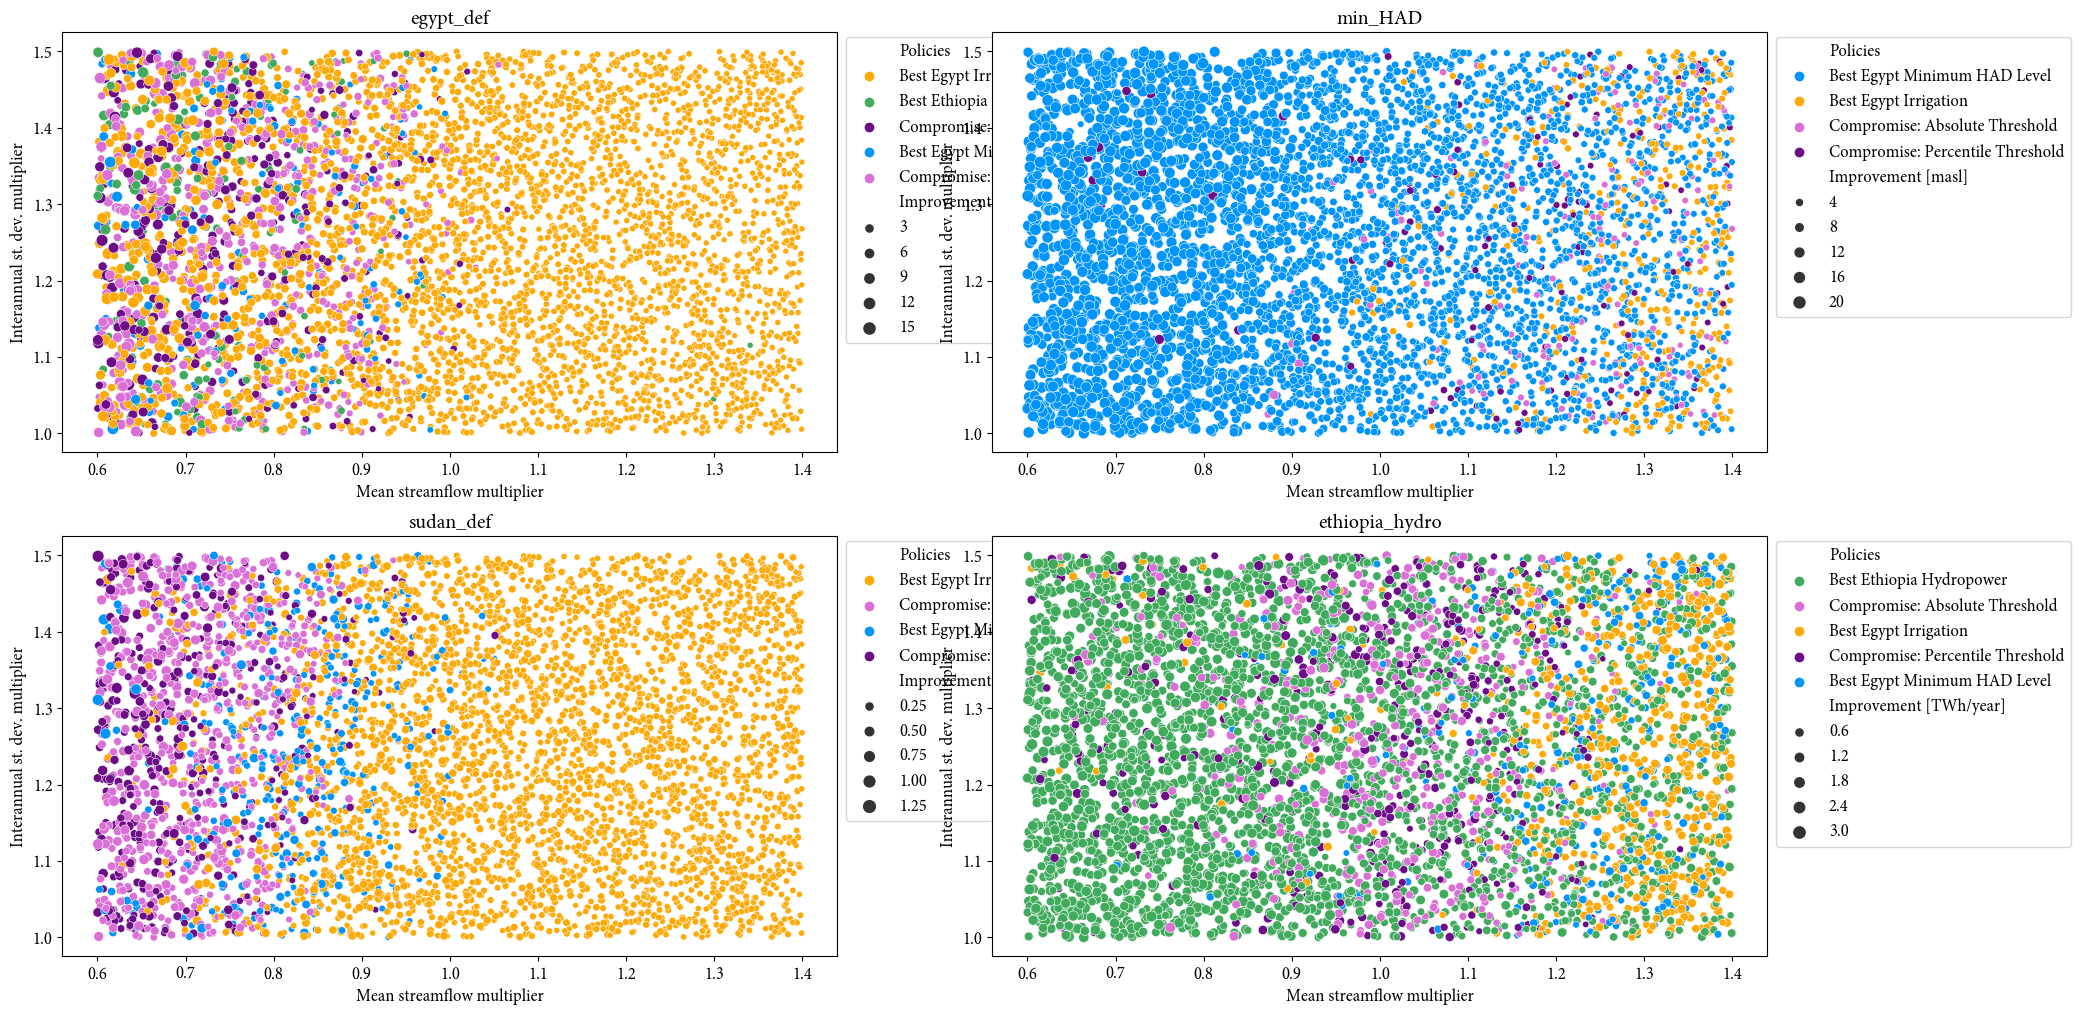

In [16]:
policy_colors = {
    "Best Egypt Irrigation": "#fdaa09",
    "Best Egypt Minimum HAD Level": "#0195fb",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Compromise: Percentile Threshold": "#6C0C86",
    "Compromise: Absolute Threshold": "orchid",
    "All Solutions": "#bdbdbd"
}
fancy_objective_names: {
    "egypt_def": "Egypt Deficit"
}
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(22, 12))

for i, obj in enumerate(outcomes.iloc[:, :-2].columns):
    print("------------")
    print(obj)
    print("------------\n")
    
    sns.scatterplot(
        data=best_performer_df[best_performer_df[f"{obj}_improvement"] > 0],
        x="mean_factor",
        y="stdev_factor",
        hue=obj,
        palette=policy_colors,
        size=f"{obj}_improvement",
        ax=ax[i // 2][i%2],
        legend="brief"
    )
    # ax.invert_yaxis()
    L=ax[i // 2][i%2].legend(bbox_to_anchor=(1, 1.01))

    L.get_texts()[0].set_text('Policies')
    if obj == "egypt_def":
        L.get_texts()[6].set_text('Improvement [BCM/year]')
        value = 6
    elif obj == "min_HAD":
        L.get_texts()[5].set_text('Improvement [masl]')
        value = 5
    elif obj == "sudan_def":
        L.get_texts()[5].set_text('Improvement [BCM/year]')
        value = 5
    else:
        L.get_texts()[6].set_text('Improvement [TWh/year]')
        value = 6
    
#     for j in range(value):
#         L.get_texts()[j].set_text('')

    ax[i // 2][i%2].yaxis.label.set_size(20)
    ax[i // 2][i%2].xaxis.label.set_size(20)
    ax[i // 2][i%2].set_xlabel("Mean streamflow multiplier", fontsize=12)
    ax[i // 2][i%2].set_ylabel("Interannual st. dev. multiplier", fontsize=12)
    ax[i // 2][i%2].set_title(obj)
# plt.savefig(
#         f"../plots/scenario_analysis/all_two_uncertainty_best_performer.pdf",
#         bbox_inches="tight",
#     )
plt.show()

------------
egypt_def
------------

------------
min_HAD
------------

------------
sudan_def
------------

------------
ethiopia_hydro
------------



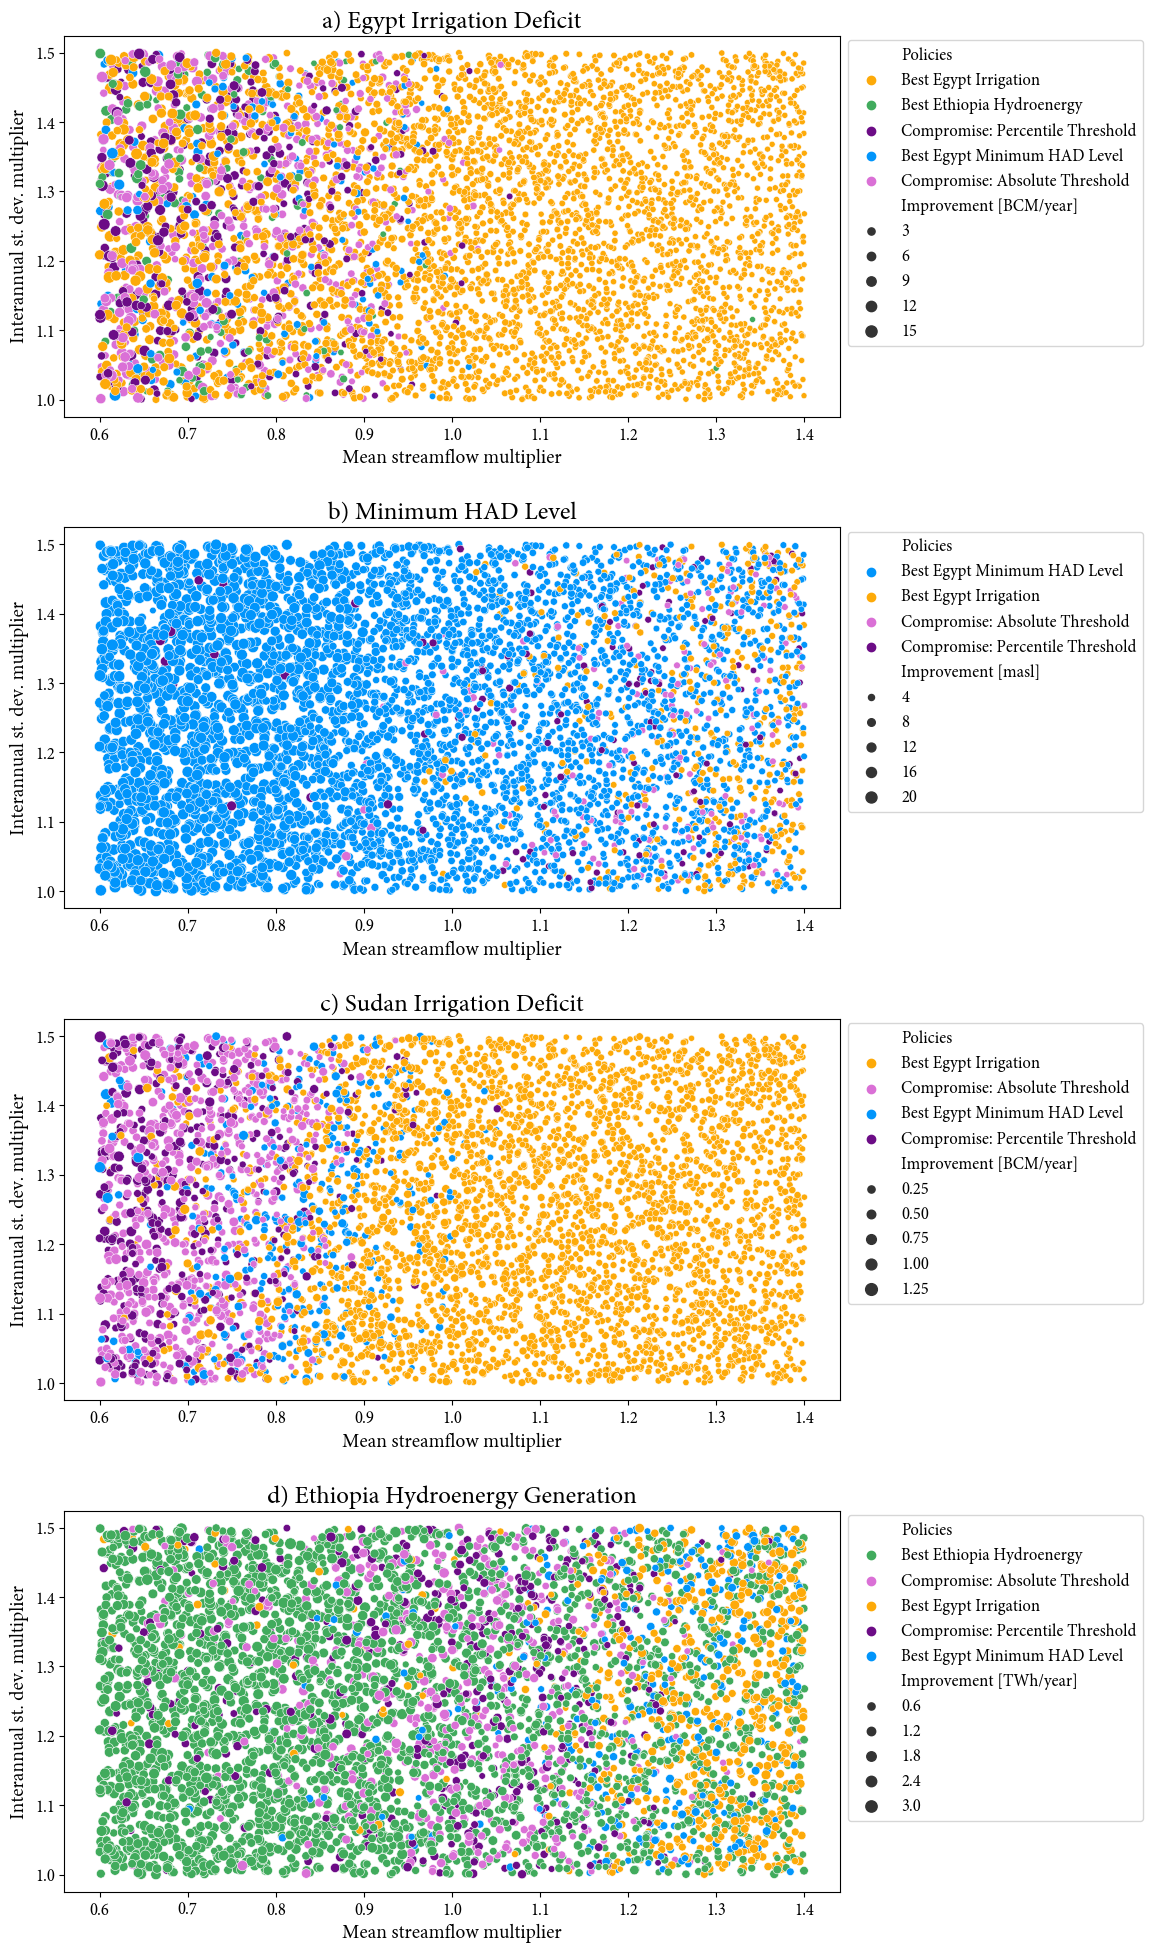

In [31]:
policy_colors = {
    "Best Egypt Irrigation": "#fdaa09",
    "Best Egypt Minimum HAD Level": "#0195fb",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Compromise: Percentile Threshold": "#6C0C86",
    "Compromise: Absolute Threshold": "orchid",
    "All Solutions": "#bdbdbd"
}
fancy_objective_names = {
    "egypt_def": "Egypt Irrigation Deficit",
    "min_HAD": "Minimum HAD Level",
    "sudan_def": "Sudan Irrigation Deficit",
    "ethiopia_hydro": "Ethiopia Hydroenergy Generation"
}
letters=['a', 'b', 'c', 'd']

fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(12, 20))

for i, obj in enumerate(outcomes.iloc[:, :-2].columns):
    print("------------")
    print(obj)
    print("------------\n")
    
    sns.scatterplot(
        data=best_performer_df[best_performer_df[f"{obj}_improvement"] > 0],
        x="mean_factor",
        y="stdev_factor",
        hue=obj,
        palette=policy_colors,
        size=f"{obj}_improvement",
        ax=ax[i],
        legend="brief"
    )
    # ax.invert_yaxis()
    L=ax[i].legend(bbox_to_anchor=(1, 1.01))

    L.get_texts()[0].set_text('Policies')
    if obj == "egypt_def":
        L.get_texts()[6].set_text('Improvement [BCM/year]')
        value = 6
    elif obj == "min_HAD":
        L.get_texts()[5].set_text('Improvement [masl]')
        value = 5
    elif obj == "sudan_def":
        L.get_texts()[5].set_text('Improvement [BCM/year]')
        value = 5
    else:
        L.get_texts()[6].set_text('Improvement [TWh/year]')
        value = 6
        
    old_label = 'Best Ethiopia Hydropower'
    new_label = 'Best Ethiopia Hydroenergy'
    for text in L.get_texts():
        if text.get_text() == old_label:
            text.set_text(new_label)
    
#     for j in range(value):
#         L.get_texts()[j].set_text('')

    ax[i].yaxis.label.set_size(20)
    ax[i].xaxis.label.set_size(20)
    ax[i].set_xlabel("Mean streamflow multiplier", fontsize=14)
    ax[i].set_ylabel("Interannual st. dev. multiplier", fontsize=14)
    ax[i].set_title(f"{letters[i]}) {fancy_objective_names[obj]}", fontsize=18)
    
fig.tight_layout(pad=2.0)
plt.savefig(
        f"../plots/scenario_analysis/all_two_uncertainty_best_performer.pdf",
        bbox_inches="tight",
    )

plt.show()

In [22]:
from ema_workbench.analysis.dimensional_stacking import (
    _prepare_experiments,
    discretize,
    plot_pivot_table,
    dim_ratios,
    plot_index,
    plot_line,
    plot_category,
)

# Use the discretize function from dimensional stacking code: Basically dividing the critical uncertainties into the specified number of bins:
best_performer_df.iloc[:, 1:5] = discretize(
    best_performer_df.iloc[:, 1:5], nbins=3, with_labels=False
)
best_performer_df

Scenario  Blue Nile Mean  White Nile Mean  Demand Growth  Atbara Mean  \
0            0               2                1              0            1   
1            1               2                0              2            1   
2            2               2                0              1            0   
3            3               2                0              2            2   
4            4               2                1              0            1   
...        ...             ...              ...            ...          ...   
4995      4995               0                0              0            0   
4996      4996               2                2              2            1   
4997      4997               0                0              2            0   
4998      4998               0                2              1            0   
4999      4999               2                1              0            1   

            egypt_irr  egypt_irr_improvement                  egypt_90  \
0     Best Egypt Irr.                   0.52           Best Egypt Irr.   
1     Best Egypt Irr.                   0.69           Best Egypt Irr.   
2     Best Egypt Irr.                   0.41      Best Egypt 90$^{th}$   
3     Best Egypt Irr.                   0.62           Best Egypt Irr.   
4     Best Egypt Irr.                   0.46           Best Egypt Irr.   
...               ...                    ...                       ...   
4995  Best Egypt Irr.                   0.22  Best Ethiopia Hydropower   
4996  Best Egypt Irr.                   0.53           Best Egypt Irr.   
4997  Best Egypt Irr.                   1.38      Compromise: Absolute   
4998  Best Egypt Irr.                   0.97      Compromise: Absolute   
4999  Best Egypt Irr.                   0.34           Best Egypt Irr.   

      egypt_90_improvement             egypt_low_had  \
0                     0.18           Best Egypt Irr.   
1                     0.15           Best Egypt Irr.   
2                     0.01           Best Egypt Irr.   
3                     0.14           Best Egypt Irr.   
4                     0.11           Best Egypt Irr.   
...                    ...                       ...   
4995                  0.08  Best Ethiopia Hydropower   
4996                  0.15           Best Egypt Irr.   
4997                  0.54  Best Ethiopia Hydropower   
4998                  0.31  Best Ethiopia Hydropower   
4999                  0.00           Best Egypt Irr.   

      egypt_low_had_improvement               sudan_irr  \
0                          0.00         Best Egypt Irr.   
1                          0.00         Best Egypt Irr.   
2                          0.00         Best Egypt Irr.   
3                          0.00          Best Egypt HAD   
4                          0.00         Best Egypt Irr.   
...                         ...                     ...   
4995                       0.78  Compromise: Percentile   
4996                       0.00          Best Egypt HAD   
4997                       0.77  Compromise: Percentile   
4998                       0.73    Compromise: Absolute   
4999                       0.00         Best Egypt Irr.   

      sudan_irr_improvement         sudan_90  sudan_90_improvement  \
0                      0.00  Best Egypt Irr.                  0.00   
1                      0.00  Best Egypt Irr.                  0.00   
2                      0.00  Best Egypt Irr.                  0.00   
3                      0.00  Best Egypt Irr.                  0.00   
4                      0.00  Best Egypt Irr.                  0.00   
...                     ...              ...                   ...   
4995                   0.00  Best Egypt Irr.                  0.00   
4996                   0.00  Best Egypt Irr.                  0.00   
4997                   0.01  Best Egypt Irr.                  0.00   
4998                   0.02  Best Egypt Irr.                  0.00   
4999            

Below are the definitions of two functions used for plotting the policy/improvement visual:

In [23]:
def my_scatter_plotter(policy_pvt, improvement_pvt, ax_plot):
    maximum_imp = improvement_pvt.max().max()
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    ax_plot.scatter(
                        (3 * k + l + 0.5),
                        (3 * i + j + 0.5),
                        s=(500 / maximum_imp) * improvement_pvt.loc[(i, j), (k, l)],
                        c=policy_colors[policy_pvt.loc[(i, j), (k, l)]],
                    )
    # ax_plot.axis("off")

    # set the tick labels
    ax_plot.set_xticks([])
    ax_plot.set_yticks([])
    ax_plot.invert_yaxis()
    ax_plot.hlines([0, 1, 2, 4, 5, 7, 8, 9], 0, 9, colors="grey")
    ax_plot.hlines([3, 6], 0, 9, linewidths=3, colors="grey")
    ax_plot.vlines([0, 1, 2, 4, 5, 7, 8, 9], 0, 9, colors="grey")
    ax_plot.vlines([3, 6], 0, 9, linewidths=3, colors="grey")

    return ax_plot


def plot_policy_shift_scenarios(
    policy_pvt,
    improvement_pvt,
    unit_imp,
    plot_labels=True,
    plot_cats=True,
    figsize=(10, 10),
    cmap="viridis",
    **kwargs,
):
    """visualize a pivot table using colors
    Parameters
    ----------
    table : Pandas DataFrame
    plot_labels : bool, optional
                 if true, display uncertain factor names
    plot_cats : bool, optional
                 if true, display category labels for each uncertain factor
    fig_size : tuple of 2 ints, optional
               size of the figure to create
    cmap : matplotlib colormap name or object, optional
           default is viridis (requires matplotlib 1.5 or higher)
    kwargs : other keyword arguments
             All other keyword arguments are passed to ax.pcolormesh.
    Returns
    -------
    Figure
    """

    # with sns.axes_style("white"):
    fig = plt.figure(figsize=figsize)

    width_ratios = dim_ratios(figsize=figsize, axis=1)
    height_ratios = dim_ratios(figsize=figsize, axis=0)

    gs = mpl.gridspec.GridSpec(
        3,
        3,
        wspace=0.01,
        hspace=0.01,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
    )

    ax_plot = fig.add_subplot(gs[2, 2])
    ax_rows = fig.add_subplot(gs[2, 0:2], facecolor="white")
    ax_cols = fig.add_subplot(gs[0:2, 2], facecolor="white")
    cax = fig.add_subplot(gs[0, 0])

    ax_plot = my_scatter_plotter(policy_pvt, improvement_pvt, ax_plot)

    # plot row labeling
    ax_rows.set_ylim(ax_plot.get_ylim())
    ax_rows.set_xlim(0, 1)
    plot_index(
        ax_rows,
        ax_plot,
        axis=1,
        index=improvement_pvt.index,
        plot_labels=plot_labels,
        plot_cats=plot_cats,
    )

    # plot column labeling
    ax_cols.set_xlim(ax_plot.get_xlim())
    ax_cols.set_ylim(0, 1)
    plot_index(
        ax_cols,
        ax_plot,
        axis=0,
        index=improvement_pvt.columns,
        plot_labels=plot_labels,
        plot_cats=plot_cats,
    )

    unique_policies = []
    for i in policy_pvt.values:
        unique_policies += list(i)

    unique_policies = list(set(unique_policies))

    legend_policies = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=pol,
            markerfacecolor=policy_colors[pol],
            markersize=10,
        )
        for pol in unique_policies
    ]
    maximum_imp = pvt_improvement.max().max()
    median_imp = pvt_improvement.median().median()

    legend_size = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"{round(maximum_imp,2)} {unit_imp}",
            markerfacecolor="k",
            markersize=math.sqrt(500),
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"{round(median_imp,2)} {unit_imp}",
            markerfacecolor="k",
            markersize=math.sqrt(500 * median_imp / maximum_imp),
        ),
    ]
    cax.axis("off")
    label_count = len(legend_policies + legend_size)
    lgnd = cax.legend(
        handles=legend_policies + legend_size,
        loc="upper center",
        bbox_to_anchor=(1.7, 0.1 + label_count * 0.2),
        frameon=False,
        fontsize="small",
        labelspacing=1.2,
    )
    lgnd.legendHandles[-2]._legmarker.set_markersize(math.sqrt(500))
    lgnd.legendHandles[-1]._legmarker.set_markersize(
        math.sqrt(500 * median_imp / maximum_imp)
    )

    return fig

0it [00:00, ?it/s]

------------
egypt_irr
------------



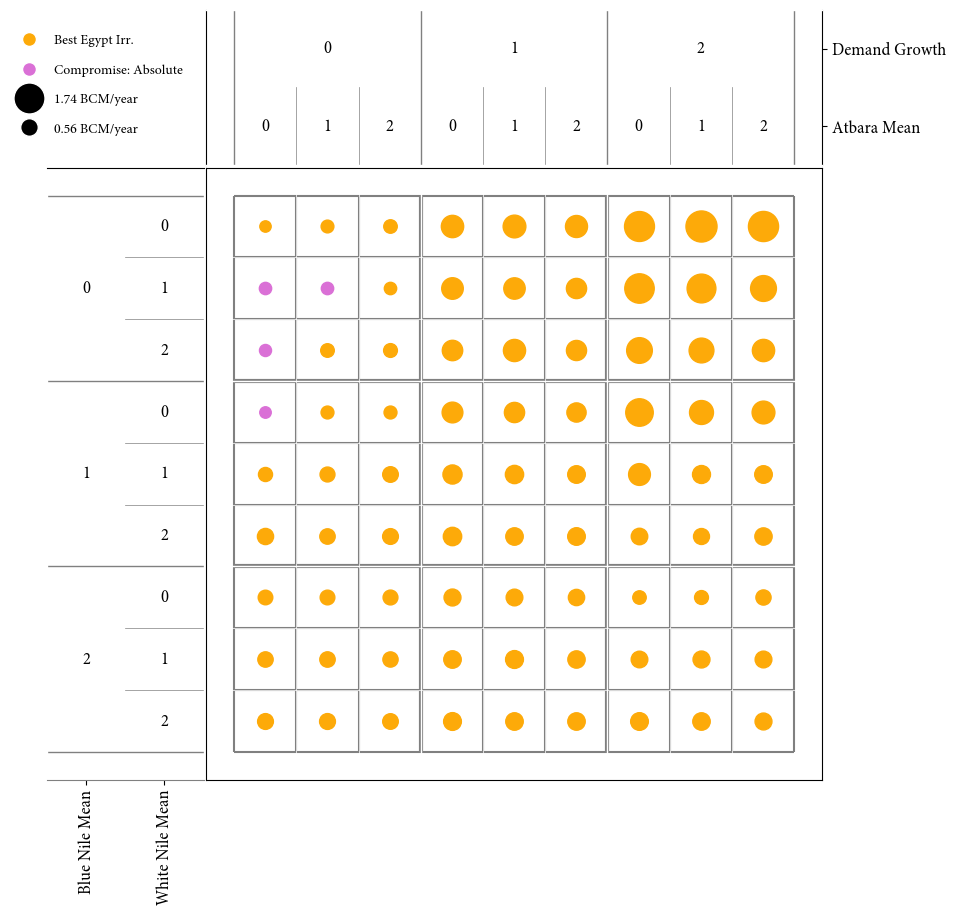

1it [00:03,  3.23s/it]

------------
egypt_90
------------



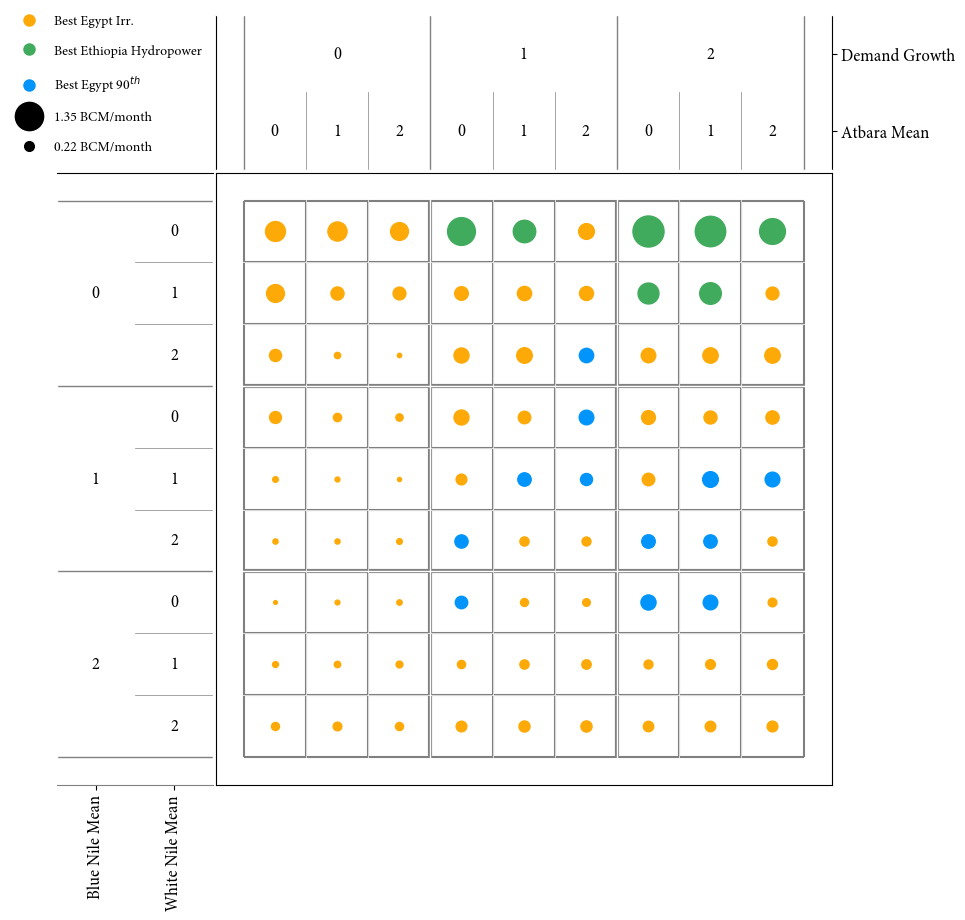

2it [00:06,  3.25s/it]

------------
egypt_low_had
------------



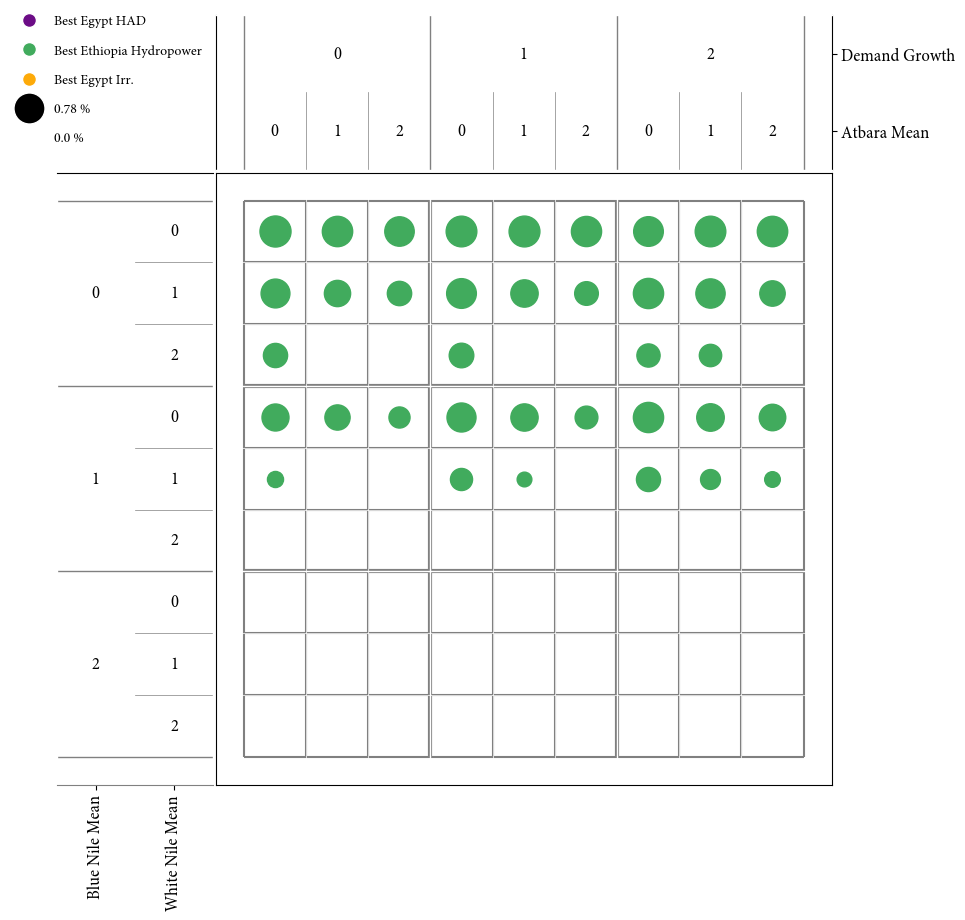

3it [00:09,  3.15s/it]

------------
sudan_irr
------------



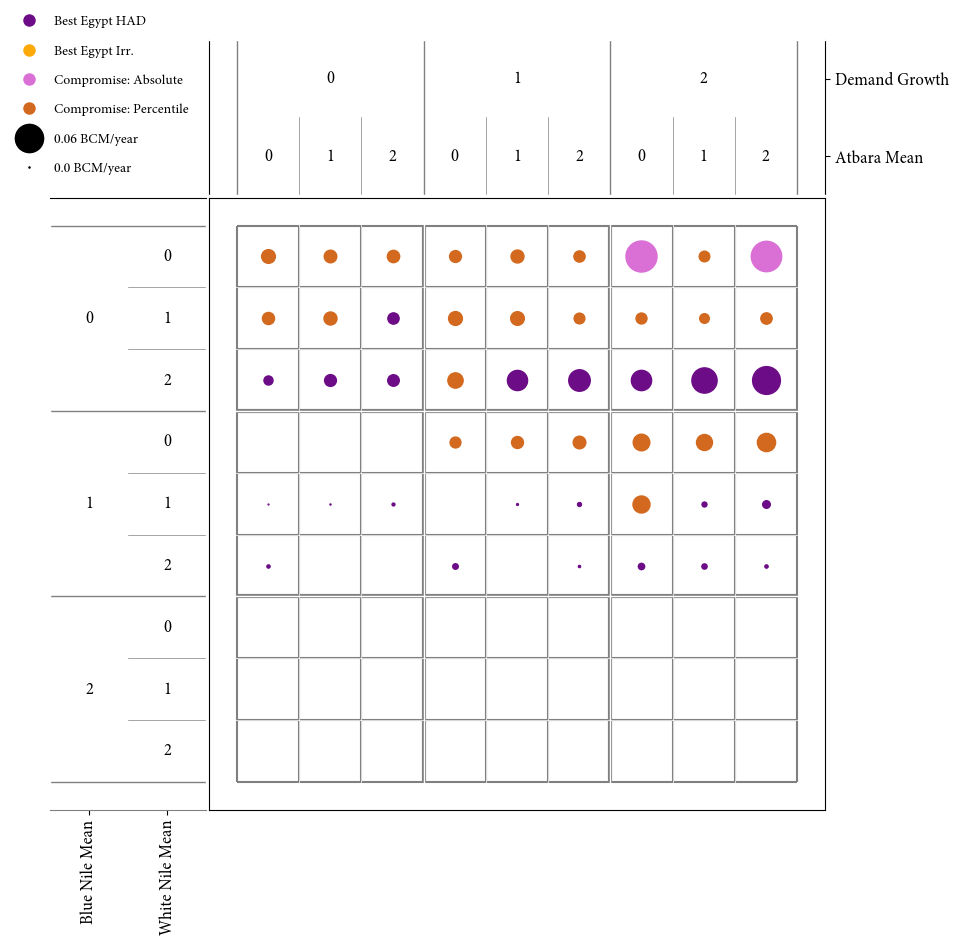

4it [00:12,  3.17s/it]

------------
sudan_90
------------



5it [00:14,  2.75s/it]

------------
ethiopia_hydro
------------



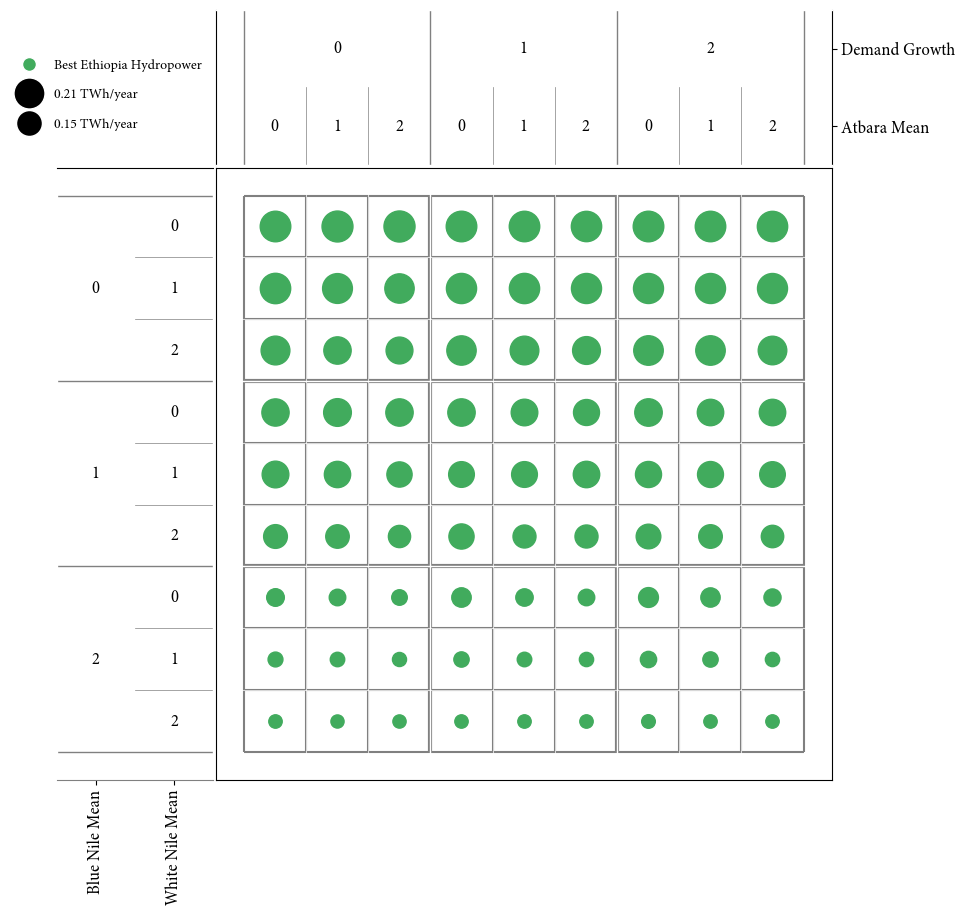

6it [00:17,  2.98s/it]


In [24]:
pivot_rows = ["Blue Nile Mean", "White Nile Mean"]
pivot_columns = ["Demand Growth", "Atbara Mean"]

policy_colors = {
    "Best Egypt 90$^{th}$": "#0195fb",
    "Best Egypt HAD": "#6C0C86",
    "Compromise: Absolute": "orchid",
    "Best Ethiopia Hydropower": "#41ab5d",
    "Best Egypt Irr.": "#fdaa09",
    "Compromise: Percentile": "chocolate",
}
units = ["BCM/year", "BCM/month", "%", "BCM/year", "BCM/month", "TWh/year"]

for u, obj in tqdm(enumerate(outcomes.iloc[:, :-2].columns)):
    print("------------")
    print(obj)
    print("------------\n")
    pvt_policy_names = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [obj]],
        values=obj,
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: statistics.mode(x),
        dropna=False,
    )

    best_performer_df[f"scenario_box_best_{obj}"] = range(5000)
    for i in range(5000):
        best_performer_df.loc[i, f"scenario_box_best_{obj}"] = pvt_policy_names.loc[
            (
                best_performer_df.loc[i, "Blue Nile Mean"],
                best_performer_df.loc[i, "White Nile Mean"],
            ),
            (
                best_performer_df.loc[i, "Demand Growth"],
                best_performer_df.loc[i, "Atbara Mean"],
            ),
        ]
        if (
            best_performer_df.loc[i, obj]
            != best_performer_df.loc[i, f"scenario_box_best_{obj}"]
        ):
            best_performer_df.loc[i, f"{obj}_improvement"] = None

    pvt_improvement = pd.pivot_table(
        best_performer_df.loc[:, pivot_rows + pivot_columns + [f"{obj}_improvement"]],
        values=f"{obj}_improvement",
        index=pivot_rows,
        columns=pivot_columns,
        aggfunc=lambda x: x.mean(),
        dropna=False,
    )

    if obj != "sudan_90":
        plot_policy_shift_scenarios(pvt_policy_names, pvt_improvement, units[u])
        plt.savefig(
            f"../plots/scenario_analysis/{obj}_best_performer_under_uncertainty.svg",
            bbox_inches="tight",
        )
        plt.show()